# DCC-GARCH model

<div style='text-align: justify;'>
The dynamic conditional correlation GARCH model aims to estimate the time-varying conditional correlation using a multivariate specification of the GARCH model. This model was introduced by (Engle, 2002). The DCC-GARCH is employed to estimate the conditional covariance matrix that will further be used in the portfolio construction process. Moreover, the conditional correlation matrix measures the time-varying relationship between the stock market indices and it provides insights for the diversification opportunities.
    </div>
    
The estimation of the conditional covariance matrix is given by:  
$$𝑄_{𝑡} = 𝑆(1−𝑎−𝑏) + 𝑎𝑒_{𝑡}𝑒_{𝑡} ^{′} + 𝑏𝑄_{𝑡−1}$$

Where et is the standardized error with mean zero and variance 1. S is the constant conditional correlation of the standardized error, which was proposed by (Bollerslev, 1990) and given by:  
$$ S = \frac{1}{T} \sum \limits _{t=1} ^{T}𝑒_{𝑡}𝑒_{𝑡} ^{′}$$
<div style='text-align: justify;'>
The parameter a measures the effect of the past squared errors or more intuitively the persistence of the volatility. In addition, the parameter b demonstrates the impact of the past DCC to the current DCC. In other words, it measures the volatility clustering effect. An important condition of the model to be mean-reverting is the summation of the parameters a, b to be less than 1.
    </div>
The estimation of the conditional correlation matrix is given by:  
$$ R_{t} = diag{Q_{t}}^{-1}Q_{t}diag{Q_{t}}^{-1}$$

In [9]:
from scipy.optimize import minimize
class my_mgarch:
#https: // github.com / srivastavaprashant / mgarch / blob / master / mgarch / mgarch.py
    def __init__(self, dist='norm'):
        if dist == 'norm' or dist == 't':
            self.dist = dist
        else:
            print("Takes pdf name as param: 'norm' or 't'.")

    def garch_fit(self, returns):
        res = minimize(self.garch_loglike, (0.01, 0.01, 0.94), args=returns,
                       bounds=((1e-6, 1), (1e-6, 1), (1e-6, 1)))
        return res.x

    def garch_loglike(self, params, returns):
        T = len(returns)
        var_t = self.garch_var(params, returns)
        LogL = np.sum(-np.log(2 * np.pi * var_t)) - np.sum((returns.A1 ** 2) / (2 * var_t))
        return -LogL

    def garch_var(self, params, returns):
        T = len(returns)
        omega = params[0]
        alpha = params[1]
        beta = params[2]
        var_t = np.zeros(T)
        for i in range(T):
            if i == 0:
                var_t[i] = returns[i] ** 2
            else:
                var_t[i] = omega + alpha * (returns[i - 1] ** 2) + beta * var_t[i - 1]
        return var_t

    def mgarch_loglike(self, params, D_t):
        # No of assets
        a = params[0]
        b = params[1]
        Q_bar = np.cov(self.rt.reshape(self.N, self.T))

        Q_t = np.zeros((self.T, self.N, self.N))
        R_t = np.zeros((self.T, self.N, self.N))
        H_t = np.zeros((self.T, self.N, self.N))

        Q_t[0] = np.matmul(self.rt[0].T / 2, self.rt[0] / 2)

        loglike = 0
        for i in range(1, self.T):
            dts = np.diag(D_t[i])
            dtinv = np.linalg.inv(dts)
            et = dtinv * self.rt[i].T
            Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
            qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

            R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))

            H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))

            loglike = loglike + self.N * np.log(2 * np.pi) + \
                      2 * np.log(D_t[i].sum()) + \
                      np.log(np.linalg.det(R_t[i])) + \
                      np.matmul(self.rt[i], (np.matmul(np.linalg.inv(H_t[i]), self.rt[i].T)))

        return loglike

    def mgarch_logliket(self, params, D_t):
        # No of assets
        a = params[0]
        b = params[1]
        dof = params[2]
        Q_bar = np.cov(self.rt.reshape(self.N, self.T))

        Q_t = np.zeros((self.T, self.N, self.N))
        R_t = np.zeros((self.T, self.N, self.N))
        H_t = np.zeros((self.T, self.N, self.N))

        Q_t[0] = np.matmul(self.rt[0].T / 2, self.rt[0] / 2)

        loglike = 0
        for i in range(1, self.T):
            dts = np.diag(D_t[i])
            dtinv = np.linalg.inv(dts)
            et = dtinv * self.rt[i].T
            Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
            qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

            R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))

            H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))

            loglike = loglike + np.log(gamma((self.N + dof) / 2.)) - np.log(gamma(dof / 2)) \
                      - (self.N / 2.) * np.log(np.pi * (dof - 2)) - np.log(np.linalg.det(H_t[i])) \
                      - ((dof + self.N) * (((np.matmul(self.rt[i],
                                                       (np.matmul(np.linalg.inv(H_t[i]), self.rt[i].T)))) / (
                                                        dof - 2.)) + 1) / 2.)

        return -loglike

    def predict(self, ndays=1):
        if 'a' in dir(self):
            Q_bar = np.cov(self.rt.reshape(self.N, self.T))

            Q_t = np.zeros((self.T, self.N, self.N))
            R_t = np.zeros((self.T, self.N, self.N))
            H_t = np.zeros((self.T, self.N, self.N))

            Q_t[0] = np.matmul(self.rt[0].T / 2, self.rt[0] / 2)

            loglike = 0
            # For each observation
            for i in range(1, self.T):
                # D_t is the standard deviation from the Garch model
                dts = np.diag(self.D_t[i])
                dtinv = np.linalg.inv(dts)
                et = dtinv * self.rt[i].T
                # Conditional Covariance Matrix
                Q_t[i] = (1 - self.a - self.b) * Q_bar + self.a * (et * et.T) + self.b * Q_t[i - 1]
                # We take the diag of the variance and again the diag and then the sqrt
                # Since the Q is var-cov matrix this will return a NxN diagonal matrix where the first diagonal has the
                # the standard deviation of the series and the rest elements are zero
                # this is a property of python
                qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

                # R_t is the correlation matrix
                R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))

                H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))

            if self.dist == 'norm':
                return {'dist': self.dist, 'cov': H_t * np.sqrt(ndays), 'corr': R_t}
                #return {'dist': self.dist, 'cov': H_t[-1] * np.sqrt(ndays)}
            elif self.dist == 't':
                return {'dist': self.dist, 'dof': self.dof, 'cov': H_t[-1] * np.sqrt(ndays)}

        else:
            print('Model not fit')

    def fit(self, returns):
        # The aim of this function is to estimate the standard deviation of the series and the
        # parameters a and b
        self.rt = np.matrix(returns)

        self.T = self.rt.shape[0]
        self.N = self.rt.shape[1]

        if self.N == 1 or self.T == 1:
            return 'Required: 2d-array with columns > 2'
        self.mean = self.rt.mean(axis=0)
        self.rt = self.rt - self.mean

        D_t = np.zeros((self.T, self.N))
        # T: num of observations
        # N: num of assets
        for i in range(self.N):
            # params include the parameters of the GARCH model
            params = self.garch_fit(self.rt[:, i])
            # D_t is the standard deviation from the Garch model
            # garch_var estimates the variance of the time series using the Garch model
            # we apply sqrt to take the standard deviation
            D_t[:, i] = np.sqrt(self.garch_var(params, self.rt[:, i]))
        self.D_t = D_t
        if self.dist == 'norm':
            # we minimize the loglikelihood function with respect to a,b
            res = minimize(self.mgarch_loglike, (0.01, 0.94), args=D_t,
                           bounds=((1e-6, 1), (1e-6, 1)),
                           # options = {'maxiter':10000000, 'disp':True},
                           )
            self.a = res.x[0]
            self.b = res.x[1]

            return {'mu': self.mean, 'alpha': self.a, 'beta': self.b}
        elif self.dist == 't':
            res = minimize(self.mgarch_logliket, (0.01, 0.94, 3), args=D_t,
                           bounds=((1e-6, 1), (1e-6, 1), (3, None)),
                           # options = {'maxiter':10000000, 'disp':True},
                           )
            self.a = res.x[0]
            self.b = res.x[1]
            self.dof = res.x[2]
            return {'mu': self.mean, 'alpha': self.a, 'beta': self.b, 'dof': self.dof}


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def import_data(path):
    # The data were downloaded from investment.com
    # Load Market index logarithmic returns
    df = pd.read_csv(path)

    # Change column name
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

    # Convert string to date time
    df['Date'] = pd.to_datetime(df['Date'])

    # Remove time
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # Set frequency to avoid errors later in the VAR model
    df['Date'] = pd.DatetimeIndex(df['Date']).to_period('B')
    #df['Date'] = pd.DatetimeIndex(df['Date'])
    # Set Datetime index
    df.set_index('Date', inplace=True)
    return df

In [4]:
# Import Returns
path1="market_indexes_ret.csv"
market_return = import_data(path1)

In [11]:
# Market indices selection
dev_country = 'US'
developed_countries = ['US', 'Germany']
market_columns = market_return.columns.values
emerging = [country for country in market_columns if country not in developed_countries]


## Plot the results

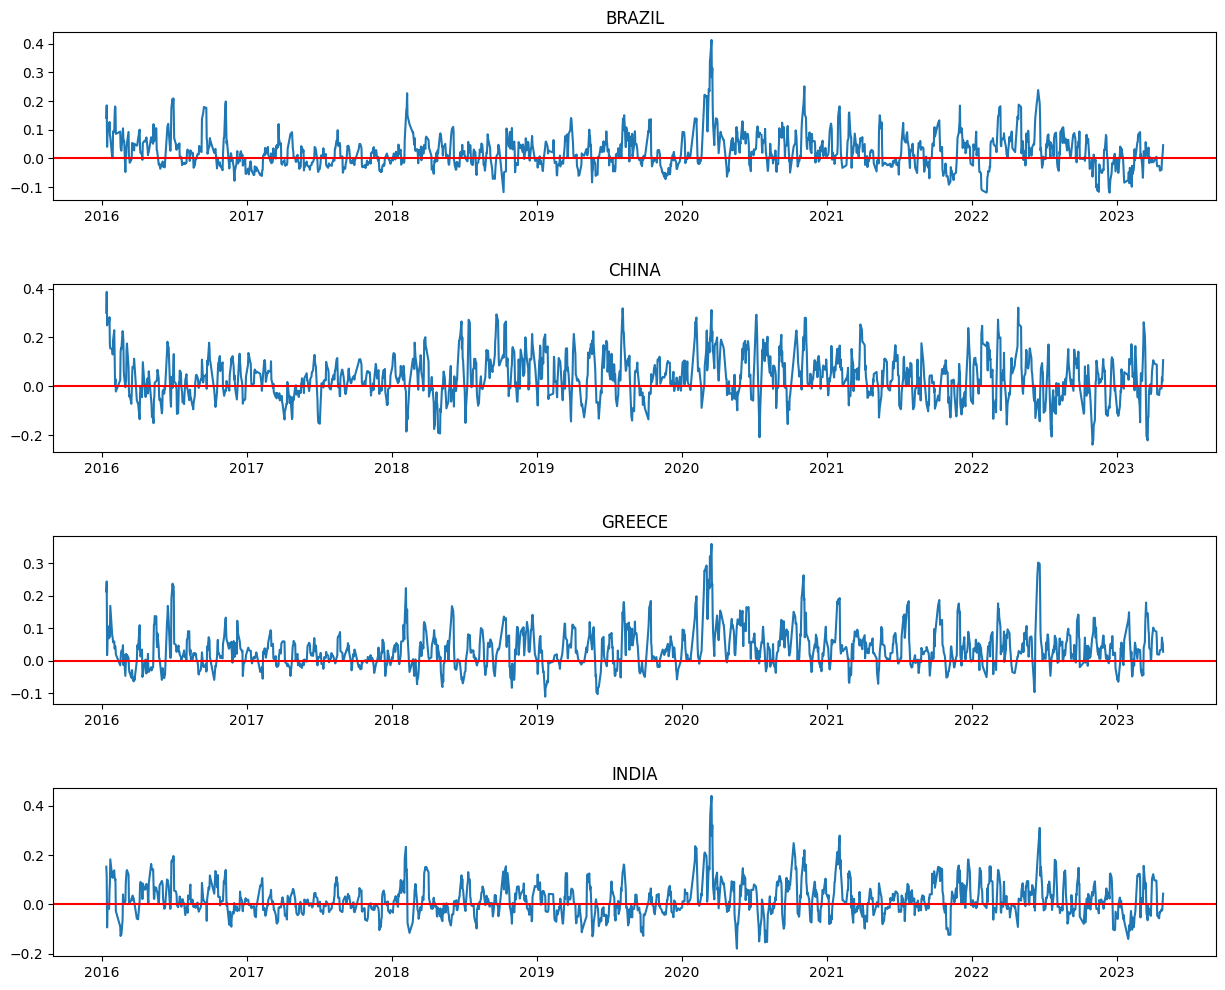

In [12]:
# define subplot grid
fig, axs = plt.subplots(nrows=len(emerging), ncols=1, figsize=(15, 12))
fig.subplots_adjust(hspace=.5,wspace=0.4)

# loop through tickers and axes
for market, ax in zip(emerging, axs.ravel()):
    rt = market_return[[dev_country, market]]

    # Fit the model
    model = my_mgarch()
    model.fit(rt)

    temp = model.predict()
    # Time-varying correlation
    DCC = temp['corr'][:, 0, 1]
    # A rolling window of 5 is used to make the results smoother
    ma25_dcc = pd.DataFrame(DCC).rolling(5).mean().dropna()
    dates = market_return[dev_country].iloc[4:].index.to_timestamp(freq=None, how='start')
    ma25_dcc.set_index(dates, inplace=True)

    ax.plot(ma25_dcc)
    ax.axhline(y=0, color='r', linestyle='-')

    # chart formatting
    ax.set_title(market.upper())
    ax.get_legend()
    ax.set_xlabel("")